# Библиотеки

In [22]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image

import torchvision.transforms.functional as TF
import cv2
import optuna
from torchinfo import summary

# Получение, трансформация, нормализация и контроль данных

In [3]:
'''Для обработки изображений х EMNIST с использованием методов Eroding, Dilating и Smoothing Images, 
 создадим функцию, для предобработки перед передачей изображений в модель'''


def preprocess_image(img):
    # Преобразуем изображение PIL в массив NumPy
    img_np = np.array(img)

    # Применяем сглаживание (Gaussian Blur)
    img_blurred = cv2.GaussianBlur(img_np, (5, 5), 0)

    # Применяем эрозию
    kernel = np.ones((3, 3), np.uint8)
    img_eroded = cv2.erode(img_blurred, kernel, iterations=1)

    # Применяем дилатацию
    img_dilated = cv2.dilate(img_eroded, kernel, iterations=1)

    # Преобразуем обратно в PIL
    img_processed = Image.fromarray(img_dilated)

    return img_processed

In [4]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data_e_r/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data_e_r/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [5]:
# получение маппинга
with open('emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

#mapping

In [6]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

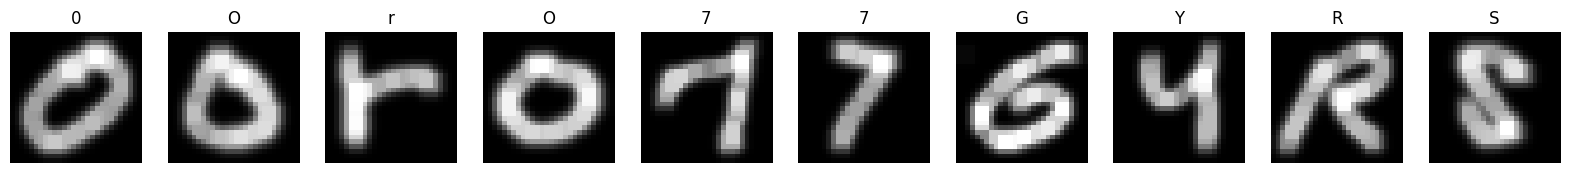

In [9]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


In [7]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
# простая модель
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Свертка с 32 фильтрами
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Свертка с 64 фильтрами
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Полносвязный слой
        self.fc2 = nn.Linear(128, 47)  # Выходной слой для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Применение свертки и активации ReLU
        x = self.pool(F.relu(self.conv2(x)))  # Применение свертки и активации ReLU
        x = x.view(-1, 64 * 7 * 7)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)  
        return x

In [17]:
# Очищаем состояние для последующей модели
def clear_training_state(model, optimizer):
    # Удаляем все параметры и градиенты
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer.state.clear()  # Очищаем состояние оптимизатора
    optimizer.param_groups.clear()  # Очищаем группы параметров

In [13]:
# Используем функцию для очистки состояния
#clear_training_state(model, optimizer)

# Инициализация модели
model_cnn = CNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [14]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.7112
Validation Accuracy: 0.8353
Epoch 2/10, Loss: 0.4190
Validation Accuracy: 0.8574
Epoch 3/10, Loss: 0.3644
Validation Accuracy: 0.8634
Epoch 4/10, Loss: 0.3288
Validation Accuracy: 0.8665
Epoch 5/10, Loss: 0.3004
Validation Accuracy: 0.8710
Epoch 6/10, Loss: 0.2776
Validation Accuracy: 0.8730
Epoch 7/10, Loss: 0.2566
Validation Accuracy: 0.8692
Epoch 8/10, Loss: 0.2378
Validation Accuracy: 0.8711
Epoch 9/10, Loss: 0.2205
Validation Accuracy: 0.8709
Epoch 10/10, Loss: 0.2063
Validation Accuracy: 0.8676


In [15]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'model_er_1.ckpt')

In [16]:
#упрощенная модель

class SimplifiedCNNModel(nn.Module):
    def __init__(self):
        super(SimplifiedCNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Уменьшено до 16 фильтров
        self.bn1 = nn.BatchNorm2d(16)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Уменьшено до 32 фильтров
        self.bn2 = nn.BatchNorm2d(32)  # Нормализация
        
        # Полносвязные слои
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(128, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = x.view(-1, 32 * 7 * 7)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [17]:
# Используем функцию для очистки состояния
clear_training_state(model_cnn, optimizer)

# Инициализация модели
model_cnn_2 = SimplifiedCNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn_2.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [18]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [19]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn_2.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn_2(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn_2.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn_2(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 1.2911
Validation Accuracy: 0.8068
Epoch 2/10, Loss: 0.8751
Validation Accuracy: 0.8306
Epoch 3/10, Loss: 0.7993
Validation Accuracy: 0.8364
Epoch 4/10, Loss: 0.7423
Validation Accuracy: 0.8427
Epoch 5/10, Loss: 0.7046
Validation Accuracy: 0.8485
Epoch 6/10, Loss: 0.6738
Validation Accuracy: 0.8539
Epoch 7/10, Loss: 0.6427
Validation Accuracy: 0.8562
Epoch 8/10, Loss: 0.6127
Validation Accuracy: 0.8588
Epoch 9/10, Loss: 0.5848
Validation Accuracy: 0.8599
Epoch 10/10, Loss: 0.5641
Validation Accuracy: 0.8630


In [20]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn_2.state_dict(), 'model_er_2.ckpt')

In [24]:
class BigCNNModel(nn.Module):
    def __init__(self):
        super(BigCNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 32 фильтра
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 фильтра
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        # Третий свертка
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 фильтров
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(256, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Свертка 3
        x = x.view(-1, 128 * 3 * 3)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [22]:
# Используем функцию для очистки состояния
clear_training_state(model_cnn_2, optimizer)

# Инициализация модели
model_cnn_3 = BigCNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn_3.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [23]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [24]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn_3.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn_3(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn_3.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn_3(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.8201
Validation Accuracy: 0.8391
Epoch 2/10, Loss: 0.5059
Validation Accuracy: 0.8695
Epoch 3/10, Loss: 0.4477
Validation Accuracy: 0.8710
Epoch 4/10, Loss: 0.4127
Validation Accuracy: 0.8769
Epoch 5/10, Loss: 0.3869
Validation Accuracy: 0.8807
Epoch 6/10, Loss: 0.3672
Validation Accuracy: 0.8832
Epoch 7/10, Loss: 0.3493
Validation Accuracy: 0.8838
Epoch 8/10, Loss: 0.3332
Validation Accuracy: 0.8807
Epoch 9/10, Loss: 0.3184
Validation Accuracy: 0.8887
Epoch 10/10, Loss: 0.3044
Validation Accuracy: 0.8858


In [25]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn_3.state_dict(), 'model_er_3.ckpt') 

In [25]:
# Загрузка предварительно обученной модели
model = BigCNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_er_3.ckpt'))

# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

/tmp/ipykernel_6223/2814997961.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_er_3.ckpt'))


Layer (type:depth-idx)                   Output Shape              Param #
BigCNNModel                              [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Conv2d: 1-7                            [1, 128, 7, 7]            73,856
├─BatchNorm2d: 1-8                       [1, 128, 7, 7]            256
├─MaxPool2d: 1-9                         [1, 128, 3, 3]            --
├─Linear: 1-10                           [1, 256]                  295,168
├─Dropout: 1-11                          [1, 256]                  --
├─Linear: 1-12                           [1, 47]                   12

[W101 00:02:15.130438373 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


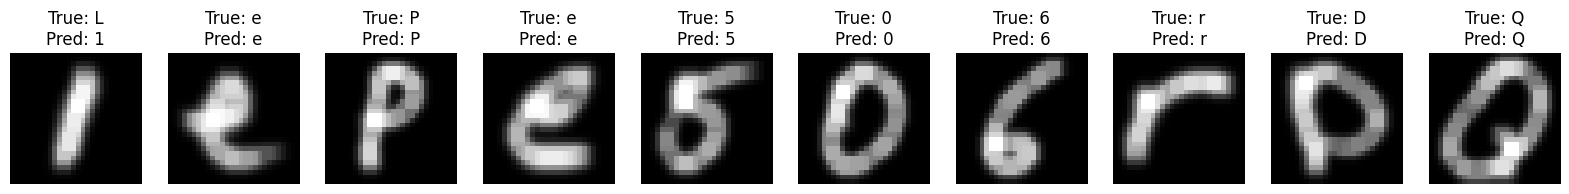

In [26]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    #print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn_3(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        #print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        #print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


# Final model

In [9]:
# Используем функцию для очистки состояния
#clear_training_state(model_cnn_3, optimizer)

In [10]:
# Определение модели
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# Инициализация модели и оптимизатора
model = ImprovedCNNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Обучение модели
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.6529
Validation Accuracy: 0.8289
Epoch 2/10, Loss: 0.4218
Validation Accuracy: 0.8560
Epoch 3/10, Loss: 0.3696
Validation Accuracy: 0.8614
Epoch 4/10, Loss: 0.3374
Validation Accuracy: 0.8683
Epoch 5/10, Loss: 0.3113
Validation Accuracy: 0.8694
Epoch 6/10, Loss: 0.2910
Validation Accuracy: 0.8714
Epoch 7/10, Loss: 0.2709
Validation Accuracy: 0.8730
Epoch 8/10, Loss: 0.2540
Validation Accuracy: 0.8747
Epoch 9/10, Loss: 0.2378
Validation Accuracy: 0.8748
Epoch 10/10, Loss: 0.2243
Validation Accuracy: 0.8747


In [12]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.90
1
Accuracy of class 1: 0.74
2
Accuracy of class 2: 0.84
3
Accuracy of class 3: 0.98
4
Accuracy of class 4: 0.90
5
Accuracy of class 5: 0.90
6
Accuracy of class 6: 0.91
7
Accuracy of class 7: 0.99
8
Accuracy of class 8: 0.94
9
Accuracy of class 9: 0.75
A
Accuracy of class 10: 0.95
B
Accuracy of class 11: 0.96
C
Accuracy of class 12: 0.95
D
Accuracy of class 13: 0.94
E
Accuracy of class 14: 0.99
F
Accuracy of class 15: 0.57
G
Accuracy of class 16: 0.94
H
Accuracy of class 17: 0.95
I
Accuracy of class 18: 0.66
J
Accuracy of class 19: 0.91
K
Accuracy of class 20: 0.96
L
Accuracy of class 21: 0.48
M
Accuracy of class 22: 0.98
N
Accuracy of class 23: 0.95
O
Accuracy of class 24: 0.36
P
Accuracy of class 25: 0.95
Q
Accuracy of class 26: 0.92
R
Accuracy of class 27: 0.96
S
Accuracy of class 28: 0.90
T
Accuracy of class 29: 0.91
U
Accuracy of class 30: 0.94
V
Accuracy of class 31: 0.92
W
Accuracy of class 32: 0.99
X
Accuracy of class 33: 0.97
Y
Accuracy of class 34: 

In [13]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), 'model_errot_f.ckpt') 

In [14]:
# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

Classes with accuracy < 0.87:
1
Accuracy of class 1: 0.74
2
Accuracy of class 2: 0.84
9
Accuracy of class 9: 0.75
F
Accuracy of class 15: 0.57
I
Accuracy of class 18: 0.66
L
Accuracy of class 21: 0.48
O
Accuracy of class 24: 0.36
f
Accuracy of class 40: 0.72
g
Accuracy of class 41: 0.66
q
Accuracy of class 44: 0.56


In [21]:
# Загрузка предварительно обученной модели
model = ImprovedCNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_errot_f.ckpt'))

/tmp/ipykernel_6223/3491297711.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_errot_f.ckpt'))


<All keys matched successfully>

In [23]:
# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

[W104 14:29:56.324605528 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNNModel                         [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Linear: 1-7                            [1, 128]                  401,536
├─Linear: 1-8                            [1, 47]                   6,063
Total params: 426,607
Trainable params: 426,607
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 1.71
Estimated Total Size (MB): 2.31

# Optuna

def objective in rotation notebook

In [ ]:
dropout_rate = 0.30540906788124
lr = 0.002184369512

In [18]:
# Используем функцию для очистки состояния
clear_training_state(model, optimizer)

# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [19]:
# Определение модели
class TunedCNNModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(TunedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Для 47 классов
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [20]:
# Инициализация модели и оптимизатора
model = TunedCNNModel()#.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Enhanced

In [26]:
class EnhancedCNNModel(nn.Module):
    def __init__(self):
        super(EnhancedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 47)  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута перед выходным слоем
        x = self.fc2(x)
        return x

In [27]:
# Используем функцию для очистки состояния
clear_training_state(model, optimizer)

# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [28]:
def train_model(model, train_loader, val_loader):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()
    
    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

        # Валидация модели после каждой эпохи
        model.eval()
        correct = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        accuracy = correct / len(val_loader.dataset)
        print(f'Validation Accuracy: {accuracy:.4f}')




In [29]:
# Инициализация и обучение модели
model = EnhancedCNNModel()
train_model(model, train_loader, val_loader)

Epoch 1/10, Loss: 1.6142
Validation Accuracy: 0.7936
Epoch 2/10, Loss: 1.2011
Validation Accuracy: 0.8151
Epoch 3/10, Loss: 1.1060
Validation Accuracy: 0.8194
Epoch 4/10, Loss: 1.0381
Validation Accuracy: 0.8306
Epoch 5/10, Loss: 0.9585
Validation Accuracy: 0.8403
Epoch 6/10, Loss: 0.9151
Validation Accuracy: 0.8413
Epoch 7/10, Loss: 0.8831
Validation Accuracy: 0.8445
Epoch 8/10, Loss: 0.8592
Validation Accuracy: 0.8445
Epoch 9/10, Loss: 0.8279
Validation Accuracy: 0.8513
Epoch 10/10, Loss: 0.8070
Validation Accuracy: 0.8475


In [30]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.10
1
Accuracy of class 1: 0.60
2
Accuracy of class 2: 0.83
3
Accuracy of class 3: 0.96
4
Accuracy of class 4: 0.93
5
Accuracy of class 5: 0.85
6
Accuracy of class 6: 0.93
7
Accuracy of class 7: 0.97
8
Accuracy of class 8: 0.95
9
Accuracy of class 9: 0.84
A
Accuracy of class 10: 0.94
B
Accuracy of class 11: 0.94
C
Accuracy of class 12: 0.94
D
Accuracy of class 13: 0.91
E
Accuracy of class 14: 0.97
F
Accuracy of class 15: 0.42
G
Accuracy of class 16: 0.91
H
Accuracy of class 17: 0.96
I
Accuracy of class 18: 0.47
J
Accuracy of class 19: 0.92
K
Accuracy of class 20: 0.97
L
Accuracy of class 21: 0.56
M
Accuracy of class 22: 0.94
N
Accuracy of class 23: 0.97
O
Accuracy of class 24: 0.93
P
Accuracy of class 25: 0.97
Q
Accuracy of class 26: 0.90
R
Accuracy of class 27: 0.97
S
Accuracy of class 28: 0.87
T
Accuracy of class 29: 0.91
U
Accuracy of class 30: 0.93
V
Accuracy of class 31: 0.94
W
Accuracy of class 32: 0.97
X
Accuracy of class 33: 0.91
Y
Accuracy of class 34: 

In [31]:
# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

Classes with accuracy < 0.87:
0
Accuracy of class 0: 0.10
1
Accuracy of class 1: 0.60
2
Accuracy of class 2: 0.83
5
Accuracy of class 5: 0.85
9
Accuracy of class 9: 0.84
F
Accuracy of class 15: 0.42
I
Accuracy of class 18: 0.47
L
Accuracy of class 21: 0.56
S
Accuracy of class 28: 0.87
Y
Accuracy of class 34: 0.83
f
Accuracy of class 40: 0.76
g
Accuracy of class 41: 0.49
q
Accuracy of class 44: 0.42


In [32]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), 'model_rot_enh.ckpt') 

In [33]:
# Загрузка предварительно обученной модели
model = ImprovedCNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_rot_enh.ckpt'))

/tmp/ipykernel_6223/1479477111.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_rot_enh.ckpt'))


<All keys matched successfully>

In [34]:
# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNNModel                         [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Linear: 1-7                            [1, 128]                  401,536
├─Linear: 1-8                            [1, 47]                   6,063
Total params: 426,607
Trainable params: 426,607
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 1.71
Estimated Total Size (MB): 2.31